# Fourier analysis for a genomics dataset  
Memebers: R. Garza, L. González, S. Nwakanma  

# Dependancies

In [5]:
import numpy as np
import pandas as pd 
from scipy import special
import scipy.sparse
# import scipy.sparse.linalg
import types
from itertools import combinations
import pylab as plt
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import csv
import os
from operator import itemgetter, attrgetter
import sys
from matplotlib.legend import Legend
from matplotlib.pyplot import figure

In [6]:
#os.mkdir("plots")
#os.mkdir("plots2")
#os.mkdir("tables")
#os.mkdir("raw_mallow_plots")
#os.mkdir("averagef6")
# os.mkdir("mallowf6")
# os.mkdir("OR Reduction plots")
# os.mkdir("OR Non-Mutation plots")

# Dataset (or)

In [7]:
gene_dat = pd.read_csv('../vcf_FA.csv',index_col='Unnamed: 0',encoding='utf-8')
matrix = gene_dat.as_matrix()
gene_mut = np.zeros((matrix.shape[0],int(np.ceil((matrix.shape[1])/2))))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
# will go through each row (# of observations)
for rows in range(matrix.shape[0]):
    for cols in range(0,matrix.shape[1]-1,2):
        # within those observations, it will go until the 
        # 2nd to last column (excludes phenotype)
        # checks to see if either the L or R gene has a mutation
        if(matrix[rows][cols]==1 or matrix[rows][cols+1]==1):
            # if it does, then in the copied matrix, 
            # a 1 will be input
            gene_mut[rows][int(cols/2)]=1
            #reason for int(cols/2) is to match up 
            #indexes with the pairing # that it's on
            #ex: 0&1 gene output val. will be in the 
            # 0 index of copied matrix 2&3 gene output 
            # val. will be in the 1 index, 4*6 in the 
            # 2nd index

In [9]:
# gets last column from original matrix, puts it as 
# last column for copied matrix
gene_mut[:,-1]=matrix[:,-1]

In [10]:
gene_mut

array([[  1.,   0.,   1., ...,   1.,   0., 196.],
       [  1.,   1.,   1., ...,   0.,   0., 173.],
       [  1.,   0.,   1., ...,   0.,   1., 198.],
       ...,
       [  1.,   0.,   1., ...,   0.,   0., 168.],
       [  1.,   0.,   1., ...,   0.,   0., 155.],
       [  1.,   0.,   1., ...,   0.,   1., 145.]])

# Spectral Analysis

In [11]:
# input: matrix
# output: list
# Takes in a matrix and returns a list that contains the numbers 
# of zeros on each line of the matrix correspondingly
def num_of_mutations(RDM):
    # make copy of data to not alter 
    tempRDM = np.copy(RDM)
    tempRDM = np.delete(tempRDM,-1,1)
    # list to count the number of ones
    nones = []
    nrows = RDM.shape[0]
    # for each row, sum the rows and save in list of ones
    for row in range(nrows):
        nones.append(sum(tempRDM[row,]))
    # create list of zeros by subracting the total amount of 
    # columns by the ones
    nzeros = [tempRDM.shape[1]]*(len(nones))
    nzeros = [a_i - b_i for a_i, b_i in zip(nzeros, nones)]
    # return list of ceros
    return nzeros

In [12]:
# input: matrix, list
# output: list of matrices
# Takes in a matrix and divides it into smalles matrices that 
# have the same amount of zeron in each line
def raw_data_partitions(RDM, nzeros):
    nrows = RDM.shape[0]
    ncols = RDM.shape[1]
    # variable to store matrices
    fPartitions = []
    # get unique values of the amount of zeros 
    distinct_amounts_zeros = np.unique(nzeros)
    distinct_amounts_zeros = np.sort(distinct_amounts_zeros)
    # for each amount of zeros
    for amount in distinct_amounts_zeros:
        list_amount_i = []
        # check every row if compatible with amount of zeros
        for row in range(nrows):
            if(nzeros[row]==amount):
                # and store them
                list_amount_i.append(RDM[row,])
        # to concatenate into a matrix
        Matrix_amount_i = np.concatenate(list_amount_i).reshape(len(list_amount_i), ncols)
        # and append it to the list of smaller matrices
        fPartitions.append((amount, Matrix_amount_i))
    # return list of smaller matrices
    return fPartitions

In [13]:
# input: list of tuples of float and matrix
# output: two lists of tuples of float and matrix
# Takes in a list of tuples that contain k 
# and data matrix with k zeros in each row and 
# separates them into two lists one with majority 
# zeros the other with minority zeros
def MinoritiesMajorities(dataPartition):
    Minorities = []
    Majorieties = []
    nvars = dataPartition[0][1].shape[1] - 1
    limit = np.floor(nvars/2)
    for elem in range(len(dataPartition)):
        k = dataPartition[elem][0]
        if (k > limit):
            Majorieties.append(dataPartition[elem])
        else:
            Minorities.append(dataPartition[elem])
    return Minorities, Majorieties

In [14]:
# input: one dimensional matrix (horizontal)
# output: tuple or int
# Takes in a row and categorizes the row by the amount of zeros 
# and returns the corresponding variables to the zeros 
# e.g. the row [1,0,1,0] with the columns 1234, return (2,4)
# e.g. the row [0,1,1,1] with columns 1234 returns 1
def categorize_row(row):
    # copy row to not alter the data
    tempRow = np.copy(row)
    tempRow = np.asarray(tempRow)
    # length of row without including the last column (which are the results)
    length = len(tempRow)-1 # minus hemoglobin
    # variable to store the variables corresponding to the zeros
    category = []
    # check line for zeros
    for i in range(length):
        if(int(tempRow[i]) == 0):
            category.append(i)
    # if it is only one zero in the row it returns the int
    if(len(category) != 1):
        # returns tuple of category
        return tuple(category)
    else:
        return category[0]

In [15]:
# input: tuple of int and matrix
# output: array
# Takes in a tuple of the number of zeros in the matrix and 
# the matrix and calculates f^(n, n-#0s)
def calc_f(PartitionTuple):
    # save all the variables
    k = PartitionTuple[0]
    data = PartitionTuple[1]
    nrows = data.shape[0]
    nvars = data.shape[1]-1
    # list to append the categories to
    rowCategory = []
    # for individual values the row categories are calculated
    # differently because we dont have to use the function 
    # combinations for the lexicographical order
    if(k == 1):
        # counter to know how many hemoglobin we add so we can average them
        counter = np.zeros(int(nvars))
        f = np.zeros(int(nvars))
        lexOrder = list(range(int(nvars)))
    else:
        # counter to know how many hemoglobin we add so we can average them
        counter = np.zeros(int(special.binom(nvars,nvars-int(k))))
        f = np.zeros(int(special.binom(nvars,nvars-int(k))))
        lexOrder = list(combinations(list(range(nvars)),int(k)))
    # for every row in the matrix add a category for each line
    # to rowCategory list
    for row in range(nrows):
        cat = categorize_row(data[row,])
        rowCategory.append(cat)
    # for every row in the data
    for row in range(nrows):
        # go through all the orgers
        for order in range(len(lexOrder)):
            # and check if the categories match
            if(rowCategory[row] == lexOrder[order]):
                # add one to the counter
                counter[order] = counter[order] + 1
                # if they do, add the results (hemoglobin) to the data vector
                f[order] = f[order] + data[row,-1]    
    # divide data vector by the counter to average it
    averagef = np.zeros(len(f))
    # be sure not to divide by zero
    for i in range(len(averagef)):
        if(int(counter[i]) == 0):
            averagef[i] = f[i]
        else:
            averagef[i] = f[i]/counter[i]
    # return data vector
    return averagef, counter

In [76]:
# input: tuple of int and matrix
# output: list of arrays
# Caluclates f^(n, n-k) for all ks and returns them 
# in a list of data vectors
def create_data_vectors(PartitionList):
    dataVectors = []
    counterVectors = []
    for data in range(len(PartitionList)):
        datavec, counter = calc_f(PartitionList[data])
        dataVectors.append(datavec)
        counterVectors.append(counter)
    # go through all data vectors and calculate average
    counter = 0
    sumDataVec = 0
    for i in range(len(dataVectors)):
        sumDataVec += sum(dataVectors[i])
        for j in range(len(dataVectors[i])):
            if(int(dataVectors[i][j]) != 0):
                counter +=1
    # compute average
    average = sumDataVec/counter
    print("average = ", average)
    imputedVectors = []
    # impute all data vectors with average
    for i in range(len(dataVectors)):
        imputed = np.zeros(len(dataVectors[i]))
        for j in range(len(imputed)):
            if(int(dataVectors[i][j]) == 0):
                imputed[j] = average
            else:
                imputed[j] = dataVectors[i][j]
        imputedVectors.append(imputed)
    return imputedVectors, counterVectors

In [17]:
# input: string or list, int
# output: list of tuples
# This function returns all the combination of the characters in the string 
# of length k as a list of tuples. It can also take a list as its first 
# argument and has the same output but treats the elements of the list 
# like characters in a string. It should be noted that this function
# "renames" the function combinations of the itertools library
# so it is more readable to the user.
def alphabet_choose_k(alphabet, k):
    return list(combinations(alphabet, int(k)))

In [18]:
# input: list of same length tuples
# output: matrix
# Takes in a tuple list each of the same size k which are all the 
# combinations of our variables and calculates the adjacency matrix
# of its Johnson Graph 
def calc_adj_mat(tuple_list):
    # type check the tuple list
    if isinstance(tuple_list, list)==False:
        return("Argument is not a list!")
    # Create adjacency matrix of size of the amount of tuples in the 
    # list on both columns and rows
    dim = len(tuple_list)  
    # SparseAdj = dok_matrix((dim,dim))
    Adj = np.zeros((dim,dim))
    # Go through the matrix 
    for i in range(dim):
        for j in range(dim):
            # if the intersection of the nodes (which are the tuples) 
            # is equal to their length - 1 then they are connected
            # and we put a one in the matrix to represent that connection
            if len(set(tuple_list[i]).intersection(set(tuple_list[j]))) == len(tuple_list[0])-1:
                # SparseAdj[i,j] = 1
                Adj[i,j] = 1
    return Adj

In [19]:
# input: matrix
# output: list of floats, list of arrays
# Takes in an adjacency matrix (which is symmetric) and calculates
# the eigen values and eigen vectors and returns them as a list of floats
# and as a list of arrays respectively. It should be noted that the 
# eigen values corrspond with the same indexed eigen vectors.
# This function "renames" the function np.linalg.eigh for the
# purpose of making it easier for the user.
def calc_eig_vec_of_adj_matrix(mat):
    eig_val, eig_vec = np.linalg.eigh(mat)
    return eig_val, eig_vec

In [20]:
# input: list of floats
# output: list of arrays
# Since the eigen vectors corresponding to the same M_i in a 
# given decomposition (n,k) have the same eigen value, this
# function (that takes in eigen vectors and eigen values in 
# order of correspondance) concatenates (as matrices) eigen 
# vectors that correspond to the same M_i and returns these 
# as a list of matricies that are the basis for the M_i's
# in ascending order (i.e. [M_0, M_1,...,M_k])
def group_eig_vecs(e_vals, e_vecs):
    # gather the distinct eigen values and sort them
    distinct_vals = np.unique(e_vals.round(decimals=4))
    distinct_vals = np.sort(distinct_vals)
    # create empty list where we will store the basis
    M_basis = []
    # for every distinct eigen value we will go through the 
    # list of eigen values and if they are equal we will add the
    # corresponding eigen vector to a list 
    for val in distinct_vals:
        # list for storing eigen vectors that correspond to 
        # the same M_i
        vec_list = []
        for i in range(len(e_vals)):
            if(val == e_vals[i].round(decimals=4)):
                vec_list.append(np.transpose(e_vecs)[i])
        # transform list of arrays into matrix to append to M basis list
        vec_list = np.array(vec_list).reshape(len(vec_list), len(vec_list[0]))
        M_basis.append(vec_list)
    # return M basis
    M_basis = np.flipud(M_basis)
    return M_basis

create dictionary with eigen basis

In [21]:
# input: array, list of matrices
# output: list of arrays
# This functions calculates the projection of the data vector 
# f onto each of the M_i basis (in the form of a matrix)
def proj_f_onto_M(f, M_basis):
    # emptylist to store the f_is as we calculate them 
    f_is = []
    # for every element of the list of M basis we will 
    # calculate f_i and append it to the list
    for i in range(len(M_basis)):
        f_is.append(proj_onto_M_i(f, M_basis[i]))
    # return list of f_i's
    return f_is

# input: array, matrix
# output: array
# This function takes in a data vector and a basis for M_i and 
# projects f onto that basis to calculate f_i
def proj_onto_M_i(f, M_i):
    # get the dimensions of M_i
    nrow = M_i.shape[0]
    ncol = M_i.shape[1]
    # create a zero vector to add the projections calculated by
    # components in the eigen vectors 
    f_i = np.zeros(ncol)
    # for each row of the basis (recall we saved the eigen vectors
    # as lines) we calculare the projections
    for j in range(nrow):
        # temporarily reshape the row to transform it from an array
        # to a one dimentional matrix (vertical)
        tmp = np.copy(M_i[j])
        tmp = tmp.reshape(len(M_i[j]),1)
        # add the new projection to f_i
        f_i = f_i + project(f, tmp)
    # return f_i
    return f_i
    
# input: one dimentional matrix, array
# output: one dimentional matrix
# This funtion calculates the projection of f onto b
def project(f, v):
    # reshape v to be a one dimentional matrix compatible 
    # for dot (or inner) product (horizontal)
    v = v.reshape(1,len(v))
    # calculate projection and return it
    result = (np.dot(v,f)/np.dot(v,np.transpose(v)))*v
    return result

In [22]:
# input: list (of ints or strings) or string, list, tuple
# output: list of arrays
# Takes in a list of data vectos given a partition (n,k)
# k being the amount of zeros in a row, implements Mallow's
# method and returns a list of data vectors as arrays
def Mallows_list(alphabet, f_iList, partition):
    # partition = (n,k)
    k = partition[1]
    # first data vector f_0 does nor change 
    # so we append it intact
    MallowsList = [np.concatenate(f_iList[0])]
    # for every data vecto f_i, 0<i<k-1, implement 
    # Mallows method
    for f_iIndex in range(1,k):
        MallowsList.append(calc_Mallow(alphabet, f_iList[f_iIndex], f_iIndex, k))
    # last data vecto f_k does not change so we append it
    # without changes
    MallowsList.append(np.concatenate(f_iList[-1]))
    # return mallows list
    return MallowsList

# input: list (of ints or strings) or string, array, int, int
# output: array
# Takes in a data vector f_i and returns Mallow's f_i
# i is for row indeces, k for columns 
def calc_Mallow(alphabet, f_i, i, k):
    # variables
    rows = list(combinations(alphabet, i))
    cols = alphabet_choose_k(alphabet, k)
    # zero array for storing values
    Mallow_f_i = np.zeros(len(rows))
    # T matrix just sums the values of the data vector 
    # where the values of (n choose i) (rows) is a subset
    # of the partition (n choose k) (columns)
    for iElem in range(len(rows)):
        for kElem in range(len(cols)):
            if(set(rows[iElem]).issubset(set(cols[kElem]))):
                # add elements of the data vector to 
                # Mallows data vector
                Mallow_f_i[iElem] = Mallow_f_i[iElem] + f_i[0,kElem]
    # return Maloow's data vector
    return Mallow_f_i

# Main function  
## Zeros in the minorities

In [78]:
# store raw data as a copy
Raw_Data = np.copy(gene_mut)

# count number of zeros on each row
num_zeros = num_of_mutations(Raw_Data)

# count the numebr of variables
num_vars = Raw_Data.shape[1]-1

# partition data by amount of zeros (list of matrices)
Sub_Data = raw_data_partitions(Raw_Data, num_zeros)

# capture just the data where 0 is in the minority
Min_Sub_Data, Maj_Sub_Data = MinoritiesMajorities(Sub_Data)

# create list of data vectors (data vector partitioned)
# i.e. data vector contains individuals, pairs, triples, etc
# we will partition the data vector into a list of arrays
# containing individual data vector, pairs data vector, etc
data_vectors_f, counter_vectors = create_data_vectors(Min_Sub_Data)

# save the k that are in the minorities
zero_minorities = []
for i in range(len(Min_Sub_Data)):
    zero_minorities.append(Min_Sub_Data[i][0])
    
# create list to contain Mallow Vectors and 
# their corresponding n-k amount of mutations
AllMallowVectors = []

# for every partition (n,k) data vector we want to calculate
# the decomposition: f = f_0 + f_1 + ... + f_k
for kindex in range(len(zero_minorities)):
    
    # partition data vector
    f = data_vectors_f[kindex]
    k = zero_minorities[kindex]
    
    # create tuples for k pairings
    variable_tuples = alphabet_choose_k(list(range(num_vars)), k)
    
    # calculate adjacency matrix and its eigen values 
    Adjacency = calc_adj_mat(variable_tuples)
    
    # calculate eigenvalues and eigenvectors of Adjacency Matrix
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(Adjacency)
    
    # create M basis to project data vector onto
    M_basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # capture correct data vector to project
    f = data_vectors_f[kindex].reshape(len(data_vectors_f[kindex]),1)
    
    # project f onto M basis
    f_list = proj_f_onto_M(f, M_basis)
    
    # Use Mallows method to transform f_is into interpretable vectors
    MalList = Mallows_list(list(range(num_vars)), f_list, (num_vars,int(k)))
    
    # Append to list of all Mallow data vectors
    AllMallowVectors.append( (num_vars-k,MalList) )

average =  158.18733609385782


In [79]:
for i in range(len(AllMallowVectors)):
    print(AllMallowVectors[i][0])

10.0
9.0
8.0
7.0


## Ones in the minorities

We currently have saved all Mallow vectors for when zero is in the minority (i.e. when we have 10,9,8,7 mutations). Now we need to analyze when zeros are in the majority (i.e. when we have 5 and 6 mutations).

An option is to just flip all the data set, but it would be more costly computation wise, so we can flip the matrices in the list $Maj\_Sub\_Data$ and run the same calculations there. 

In [80]:
# input: list of tuples of length two (float, matrix)
# output: list of tuples of length two (float, matrix)
# This function takes in a list of tuples where the 
# first value is the amount of zeros on each row (denoted k) of the 
# matrix (second value of tuple) and it flips the matricies
# i.e. changes all the 1's to 0's and vice versa
# it also changes the k to the total amount of variables 
# (denoted n) minus k (so it does keep count of the amount of zeros)
def flipMajorities(Majority_Data):
    New_Minorities = []
    for tupIndex in range(len(Majority_Data)):
        k = Majority_Data[tupIndex][0]
        data = Majority_Data[tupIndex][1]
        ncols = data.shape[1]-1
        nrows = data.shape[0]
        newMatrix = np.zeros((nrows, ncols+1))
        for i in range(nrows):
            for j in range(ncols):
                if(int(data[i,j]) == 1):
                    newMatrix[i,j] = 0
                elif(int(data[i,j]) == 0):
                    newMatrix[i,j] = 1
        # copy hemoglobin as is
        for h in range(nrows):
            newMatrix[h, -1] = data[h, -1]
        New_Minorities.append( (ncols-k, newMatrix) )
    return New_Minorities

In [81]:
New_Min_Data = flipMajorities(Maj_Sub_Data)

In [82]:
# create list of data vectors (data vector partitioned)
# i.e. data vector contains individuals, pairs, triples, etc
# we will partition the data vector into a list of arrays
# containing individual data vector, pairs data vector, etc
data_vectors_f2, counter_vectors2 = create_data_vectors(New_Min_Data)

# save the k that are in the minorities
zero_minorities2 = []
for i in range(len(New_Min_Data)):
    zero_minorities2.append(New_Min_Data[i][0])
    
# create list to contain Mallow Vectors and 
# their corresponding n-k amount of mutations
AllMallowVectors2 = []

# for every partition (n,k) data vector we want to calculate
# the decomposition: f = f_0 + f_1 + ... + f_k
for kindex2 in range(len(zero_minorities2)):
    
    # partition data vector
    f2 = data_vectors_f2[kindex2]
    k2 = zero_minorities2[kindex2]
    
    # create tuples for k pairings
    variable_tuples = alphabet_choose_k(list(range(num_vars)), k2)
    
    # calculate adjacency matrix and its eigen values 
    Adjacency = calc_adj_mat(variable_tuples)
    
    # calculate eigenvalues and eigenvectors of Adjacency Matrix
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(Adjacency)
    
    # create M basis to project data vector onto
    M_basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # capture correct data vector to project
    f = data_vectors_f2[kindex2].reshape(len(data_vectors_f2[kindex2]),1)
    
    # project f onto M basis
    f_list = proj_f_onto_M(f, M_basis)
    
    # Use Mallows method to transform f_is into interpretable vectors
    MalList = Mallows_list(list(range(num_vars)), f_list, (num_vars,int(k2)))
    
    # Append to list of all Mallow data vectors
    AllMallowVectors2.append( (k2,MalList) )

average =  163.47058823529412


In [29]:
for i in range(len(AllMallowVectors2)):
    print(AllMallowVectors2[i][0])

6.0
5.0


# Data vector for $f^{(13,5)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,5)}_i$ where $i = 1,2,3,4,5$  

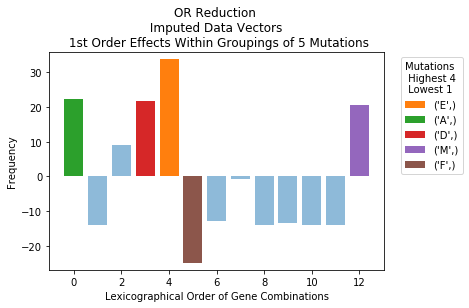

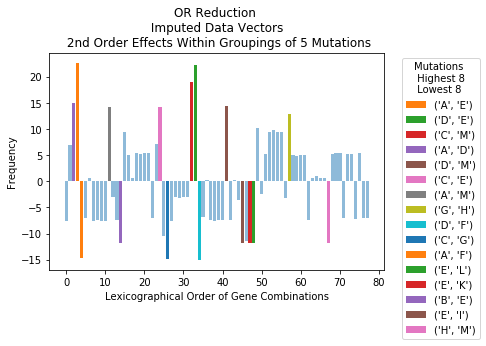

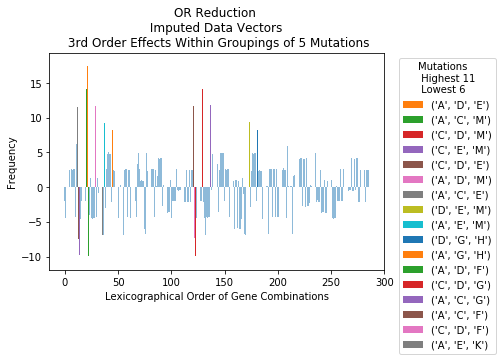

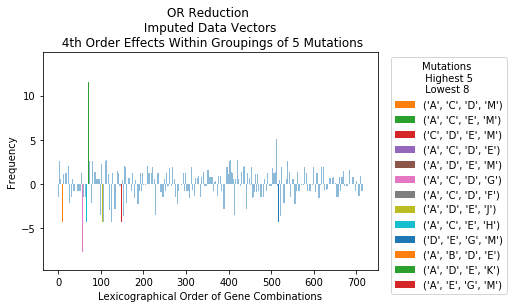

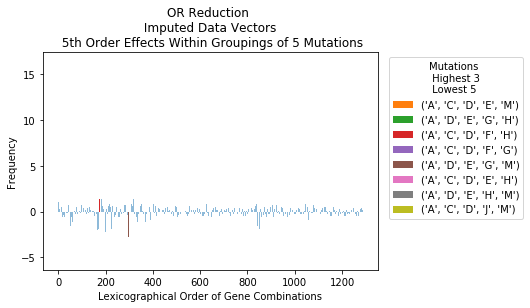

In [448]:
# # plot f^5_1, f^5_2, f^5_3, f^5_4, f^5_5
# k = mutations
# order range from 1 to 5
p = ([4,1],[8,8],[11,6],[5,8],[3,5])
l = 1.25
for o in range(1,6):
    color_peaks(AllMallowVectors2[1][1][o],order=o,k=5,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^5_i$ where $i=1,...,5$

In [32]:
# match values with ids
IDMalListf5 = []
for order in range(1,len(AllMallowVectors2[1][1])):
    fi = AllMallowVectors2[1][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf5.append(newfi)

In [33]:
# [i] is the order-1 [e.g. 0 is first order]
# sorted(IDMalListf5[4], key = itemgetter(1), reverse = False)[:5] # True False

In [55]:
k = 5
combs = combinations_mutations[3][1]
real_f5s = []
for fi in range(1, len(AllMallowVectors2[1][1])):
    f = AllMallowVectors2[1][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f5s.append(newf)

In [56]:
# real values in f^4
# [i]
# i is the order-1 [e.g. 0 is first order]
# real_f5s[0]

# sorted real values in f^4
# [i]
# i is the order-1 [e.g. 0 is first order]
order = 5
rev = 0
top = 10
sorted(real_f5s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

[((0, 2, 3, 5, 6), -4.355275443510946),
 ((0, 3, 4, 6, 12), -2.8006535947712425),
 ((0, 2, 3, 4, 7), -2.7880485527541663),
 ((0, 3, 4, 7, 12), -2.514939309057113),
 ((0, 2, 3, 9, 12), -2.204014939309178),
 ((2, 3, 4, 5, 12), -2.2040149393089568),
 ((0, 2, 3, 11, 12), -2.196451914098894),
 ((0, 1, 2, 3, 12), -2.196451914098752),
 ((0, 2, 4, 5, 12), -2.1914098972922478),
 ((0, 2, 3, 4, 6), -1.981325863678902)]

# Data vector for $f^{(13,6)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,6)}_i$ where $i = 1,2,...,6$  

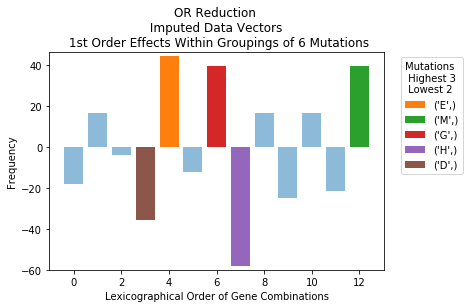

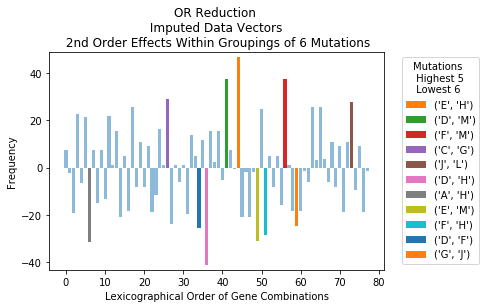

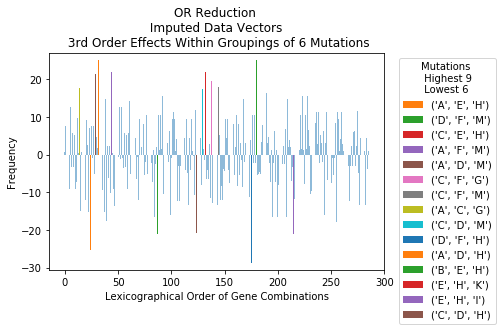

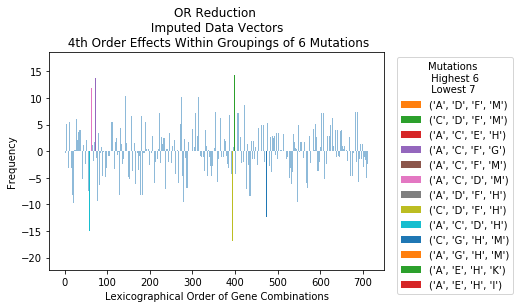

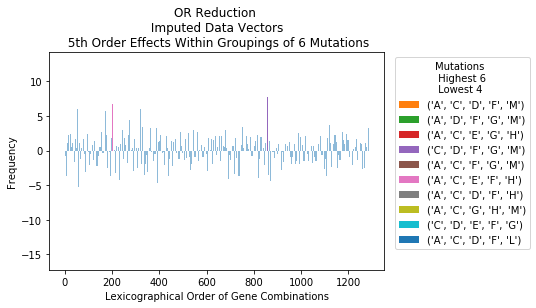

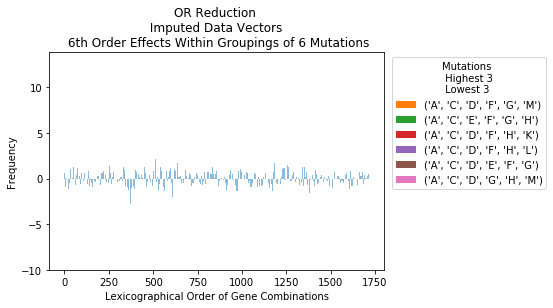

In [449]:
# # plot f^6_1, f^6_2, f^6_3, f^6_4,..., f^6_6
# k = 6
# # order range from 1 to 6
p = ([3,2],[5,6],[9,6],[6,7],[6,4],[3,3])
l = 1.25
for o in range(1,7):
    color_peaks(AllMallowVectors2[0][1][o],order=o,k=6,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^6_i$ where $i=1,...,6$

In [57]:
# match values with ids
IDMalListf6 = []
for order in range(1,len(AllMallowVectors2[0][1])):
    fi = AllMallowVectors2[0][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf6.append(newfi)

In [58]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDMalListf6[5], key=itemgetter(1))[:9]

[((0, 2, 3, 5, 7, 11), -7.986274509803826),
 ((0, 2, 3, 4, 5, 6), -5.0843137254902295),
 ((0, 2, 3, 6, 7, 12), -4.411484593837446),
 ((0, 2, 3, 5, 6, 7), -3.5084033613444685),
 ((0, 2, 3, 5, 8, 12), -2.800280112044957),
 ((0, 1, 2, 3, 5, 12), -2.800280112044942),
 ((0, 2, 3, 5, 10, 12), -2.800280112044748),
 ((0, 3, 5, 6, 11, 12), -2.696078431372589),
 ((0, 3, 5, 6, 7, 9), -2.621568627451041)]

In [59]:
k = 6
combs = combinations_mutations[4][1]
real_f6s = []
for fi in range(1, len(AllMallowVectors2[0][1])):
    f = AllMallowVectors2[0][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f6s.append(newf)

In [60]:
# real values in f^6_i
# [i]
# i is the order-1 [e.g. 0 is first order]
real_f6s[0]

[((0,), -17.977375565613603),
 ((2,), -3.9773755656204575),
 ((3,), -35.506787330332095),
 ((4,), 44.31674208143497),
 ((5,), -12.036199094991126),
 ((6,), 39.434389140266546),
 ((7,), -58.03619909502112),
 ((9,), -24.742081447942972),
 ((11,), -21.271493212656555),
 ((12,), 39.78733031674352)]

In [62]:
# sorted real values in f^6
# [i]
# i is the order+1 [e.g. 0 is first order]
order = 2
rev = 0
top = 25
sorted(real_f6s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

[((3, 7), -41.299465240637794),
 ((0, 7), -31.737967914437498),
 ((5, 7), -28.497326203212868),
 ((3, 5), -25.679144385022184),
 ((6, 9), -24.67379679144863),
 ((2, 7), -24.10160427807201),
 ((2, 11), -19.51871657753697),
 ((0, 3), -19.449197860973015),
 ((5, 11), -15.855614973266682),
 ((0, 9), -15.04812834224297),
 ((0, 11), -13.155080213895582),
 ((2, 3), -11.81283422460793),
 ((9, 12), -9.363636363641632),
 ((5, 9), -8.278074866313275),
 ((0, 5), -6.64705882352683),
 ((7, 12), -6.17112299465552),
 ((6, 12), -5.946524064177814),
 ((2, 9), -5.94117647058327),
 ((3, 11), -5.187165775394763),
 ((0, 2), -2.251336898403592),
 ((4, 11), -1.9999999999954303),
 ((4, 6), -0.5347593582830545),
 ((2, 5), 0.9893048128412902),
 ((6, 7), 1.106951871650795),
 ((3, 9), 2.390374331555673)]

# Data vector for $f^{(13,13-7)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,13-7)}_i$ where $i = 1,2,...,6$  

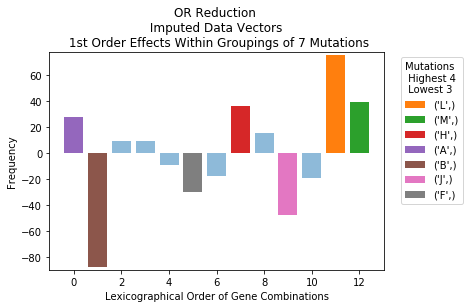

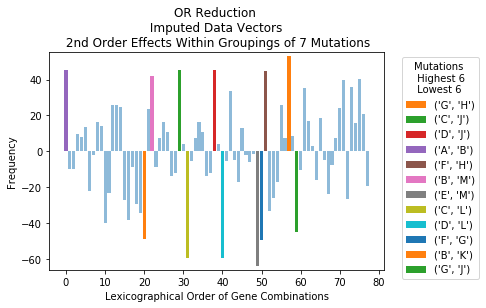

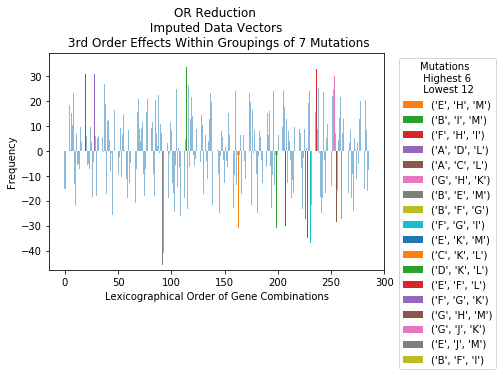

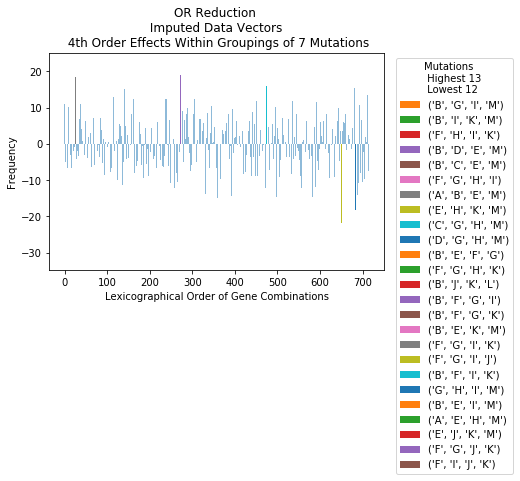

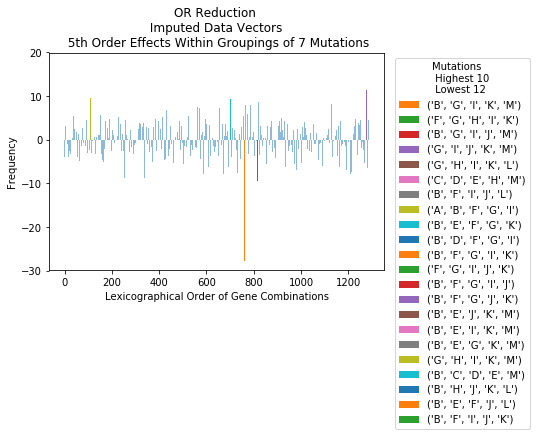

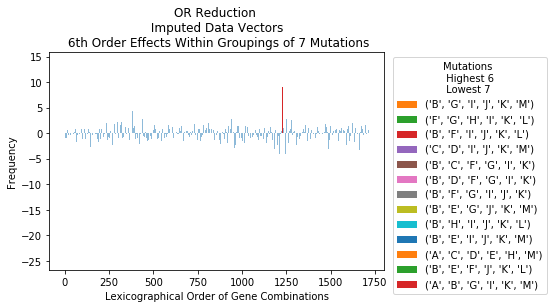

In [450]:
# # plot f^(13-7)_1, f^(13-7)_2, f^(13-7)_3,..., f^(13-7)_6
# k = 7
# order range from 1 to 6
p = ([4,3],[6,6],[6,12],[13,12],[10,12],[6,7])
l = 1.25
for o in range(1,7):
    color_peaks(AllMallowVectors[3][1][o],order=o,k=7,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^{13-7}_i$ where $i=1,...,6$

In [548]:
# match values with ids
IDMalListf7 = []
for order in range(1,len(AllMallowVectors[3][1])):
    fi = AllMallowVectors[3][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf7.append(newfi)

In [549]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDMalListf7[5], key=itemgetter(1))[:9]

[((1, 5, 6, 8, 9, 10), -24.783748151434686),
 ((1, 4, 6, 9, 10, 12), -9.902783282394939),
 ((1, 7, 8, 9, 10, 11), -8.98168745275894),
 ((1, 4, 8, 9, 10, 12), -5.842700138026271),
 ((0, 2, 3, 4, 7, 12), -5.7296080219529335),
 ((1, 4, 5, 9, 10, 11), -4.91444271911673),
 ((0, 1, 6, 8, 10, 12), -4.7571030102861505),
 ((5, 6, 7, 8, 9, 11), -4.698268181668699),
 ((1, 2, 6, 8, 10, 12), -4.386252505833194)]

In [550]:
k = 7
combs = combinations_non_mutations[3][1]
# combs = combinations_mutations[4][1]
real_f7s = []
for fi in range(1, len(AllMallowVectors[3][1])):
    f = AllMallowVectors[3][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f7s.append(newf)

In [564]:
# real values in f^(13-7)_i
# [i]
# i is the order-1 [e.g. 0 is first order]
# len(real_f7s[0])

In [588]:
# sorted real values in f^(13-7)
# [i]
# i is the order-1 [e.g. 0 is first order]
order = 6
rev = 0
top = 4
sorted(real_f7s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

[((1, 5, 6, 8, 9, 10), -24.783748151434686),
 ((1, 4, 6, 9, 10, 12), -9.902783282394939),
 ((1, 7, 8, 9, 10, 11), -8.98168745275894),
 ((1, 4, 8, 9, 10, 12), -5.842700138026271)]

# Data vector for $f^{(13,13-8)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,13-8)}_i$ where $i = 1,2,...,5$  

In [ ]:
# # plot f^(13-8)_1, f^(13-8)_2, f^(13-8)_3,..., f^(13-8)_5
# k = 8
# order range from 1 to 5
p = ([4,3],[7,10],[12,12],[7,7],[4,4])
l = 1.25
for o in range(1,6):
    color_peaks(AllMallowVectors[2][1][o],order=o,k=8,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^{13-8}_i$ where $i=1,...,5$

In [599]:
# match values with ids
IDMalListf8 = []
for order in range(1,len(AllMallowVectors[2][1])):
    fi = AllMallowVectors[2][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf8.append(newfi)

In [600]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDMalListf8[0], key=itemgetter(1))[:9]

[((1,), -77.36005998834564),
 ((2,), -69.54936295590774),
 ((4,), -65.67337951907395),
 ((3,), -51.54936295590431),
 ((6,), -41.673379518983445),
 ((8,), -21.546084833032516),
 ((12,), 28.889940011688154),
 ((7,), 35.26330095027918),
 ((5,), 35.70129266869366)]

In [601]:
k = 8
combs = combinations_non_mutations[2][1]
# combs = combinations_mutations[4][1]
real_f8s = []
for fi in range(1, len(AllMallowVectors[2][1])):
    f = AllMallowVectors[2][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f8s.append(newf)

In [617]:
# real values in f^(13-8)_i
# [i]
# i is the order-1 [e.g. 0 is first order]
# real_f8s[0]

# sorted real values in f^(13-8)
# [i]
# i is the order+1 [e.g. 0 is first order]
order = 5
rev = 0
top = 4
sorted(real_f8s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

[((1, 4, 8, 9, 10), -19.7826938665966),
 ((2, 8, 10, 11, 12), -12.060948163484383),
 ((1, 6, 8, 10, 11), -10.791338087569889),
 ((4, 6, 8, 9, 10), -10.438916548906167)]

# Data vector for $f^{(13,13-9)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,13-9)}_i$ where $i = 1,2,3,4$ 

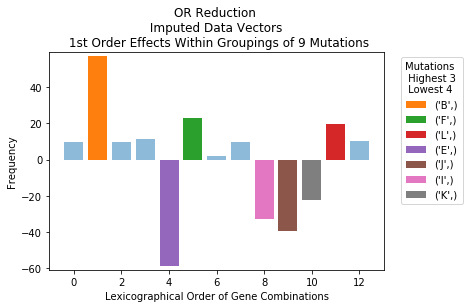

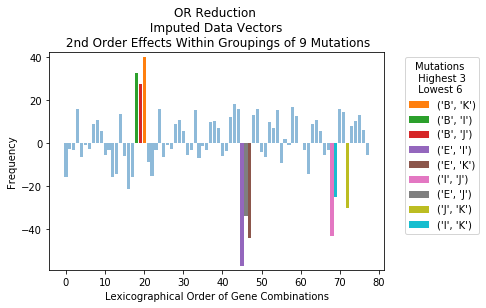

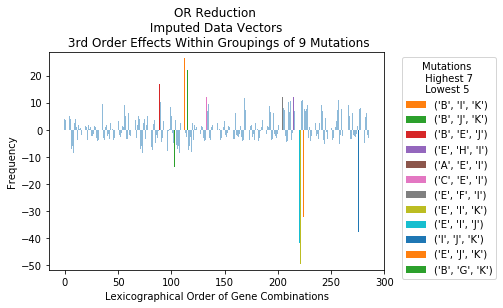

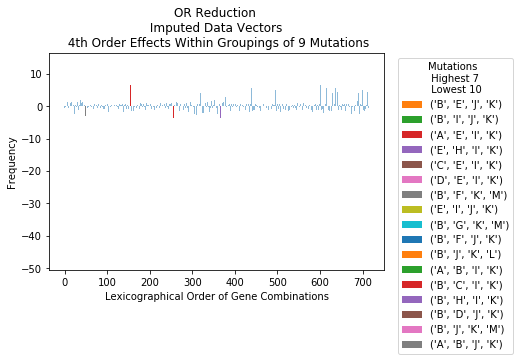

In [452]:
# # plot f^(13-9)_1, f^(13-9)_2,..., f^(13-9)_4
# k = 9
# order range from 1 to 4
p = ([3,4],[3,6],[7,5],[7,10])
l = 1.25
for o in range(1,5):
    color_peaks(AllMallowVectors[1][1][o],order=o,k=9,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^{13-9}_i$ where $i=1,...,4$

In [618]:
# match values with ids
IDMalListf9 = []
for order in range(1,len(AllMallowVectors[1][1])):
    fi = AllMallowVectors[1][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf9.append(newfi)

In [619]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDMalListf9[0], key=itemgetter(1))[:3]

[((4,), -58.75139087965626),
 ((9,), -39.551390879661454),
 ((8,), -32.511880872763165)]

In [620]:
k = 9
combs = combinations_non_mutations[1][1]
# combs = combinations_mutations[4][1]
real_f9s = []
for fi in range(1, len(AllMallowVectors[1][1])):
    f = AllMallowVectors[1][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f9s.append(newf)

In [637]:
# real values in f^(13-9)_i
# [i]
# i is the order-1 [e.g. 0 is first order]
len(real_f9s[0])

# sorted real values in f^(13-9)
# [i]
# i is the order-1 [e.g. 0 is first order]
# order = 4
# rev = 0
# top = 10
# sorted(real_f9s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

10

# Data vector for $f^{(13,13-10)}$ with average instead of zeros

#### Plotting and saving the graphs of $f^{(13,13-10)}_i$ where $i = 1,2,3$ 

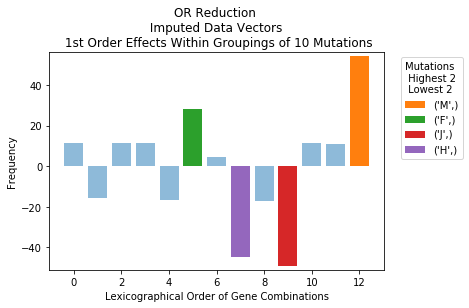

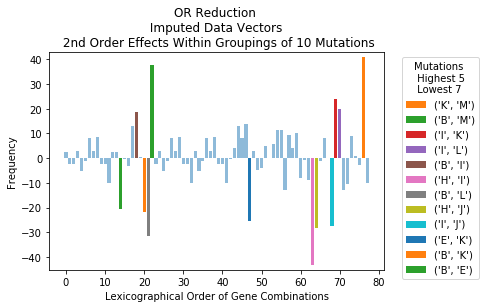

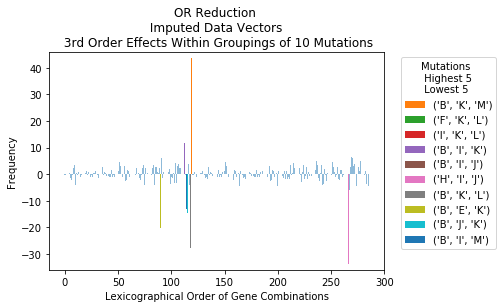

In [453]:
# # plot f^(13-10)_1, f^(13-10)_2, f^(13-10)_3
# k = 10
# order range from 1 to 3
p = ([2,2],[5,7],[5,5])
l = 1.25
for o in range(1,4):
    color_peaks(AllMallowVectors[0][1][o],order=o,k=10,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=1,save=1)
    l += 0.05

#### Fucntions for accesing spcefic values in the averaged $f^{13-10}_i$ where $i=1,2,3$

In [638]:
# match values with ids
IDMalListf10 = []
for order in range(1,len(AllMallowVectors[0][1])):
    fi = AllMallowVectors[0][1][order]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDMalListf10.append(newfi)

In [639]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDMalListf10[0], key=itemgetter(1))[:3]

[((9,), -49.08169294473814),
 ((7,), -44.89435685088045),
 ((8,), -17.143701226310718)]

In [640]:
k = 10
combs = combinations_non_mutations[0][1]
# combs = combinations_mutations[4][1]
real_f10s = []
for fi in range(1, len(AllMallowVectors[0][1])):
    f = AllMallowVectors[0][1][fi]
    newf = []
    lexOrder = alphabet_choose_k(list(range(13)), fi)
    for lex in range(len(lexOrder)):
        if(isin_data(lexOrder[lex], combs)):
            newf.append( (lexOrder[lex], f[lex]) )
    real_f10s.append(newf)

In [655]:
# real values in f^(13-10)_i
# [i]
# i is the order-1 [e.g. 0 is first order]
# real_f10s[0]

# sorted real values in f^(13-10)
# [i]
# i is the order-1 [e.g. 0 is first order]
order = 3
rev = 0
top = 5
sorted(real_f10s[order-1], key = itemgetter(1), reverse = rev)[:top] # [:7] True False

[((7, 8, 9), -34.01643941136693),
 ((1, 10, 11), -27.905386577995337),
 ((1, 4, 10), -20.116468550236714),
 ((1, 9, 10), -14.481757255090514),
 ((1, 8, 12), -13.216439411366924)]

# Tables for combinations of non-mutations

In [35]:
# intput:
# output:
# Given a matrix with only nz number of zeros on each row
# returns an array of tuples where each tuple is a distinct
# combination of mutations in at least one row of the matrix
# the length of the tuples are 13-nz
def combination_tables_nonmutations(mat):
    nrows = mat.shape[0]
    tups = []
    for row in range(nrows):
        tups.append(categorize_row(mat[row]))
    return list(set(tups))

In [36]:
# list to hold combinations of mutations
combinations_non_mutations = []

# for every partition of data of the form (#zero, sub-data)
# create a table and save it that contains its distinct
# combinations of mutations
for data in range(len(Min_Sub_Data)):
    nzero = Sub_Data[data][0]
    matr = Sub_Data[data][1]
    tupslist = combination_tables_nonmutations(matr)
    combinations_non_mutations.append((num_vars-nzero, tupslist))
    #df = pd.DataFrame(np.asanyarray(tupslist))
    #df.to_csv("tables/combinations_%d_mutations.csv"%(num_vars-nzero))

# Tables for combinations of mutations

In [38]:
# intput:
# output:
# Given a matrix with only nz number of zeros on each row
# returns an array of tuples where each tuple is a distinct
# combination of mutations in at least one row of the matrix
# the length of the tuples are 13-nz
def combination_tables(mat, nz):
    nrows = mat.shape[0]
    tups = []
    for row in range(nrows):
        tups.append(categorize_row2(mat[row]))
    return list(set(tups))

In [39]:
# input: one dimensional matrix (horizontal)
# output: tuple or int
# Takes in a row and categorizes the row by the amount of ones 
# and returns the corresponding variables to the ones 
# e.g. the row [1,0,1,0] with the columns 1234, return (1,3)
# e.g. the row [0,0,0,1] with columns 1234 returns 4
def categorize_row2(row):
    # copy row to not alter the data
    tempRow = np.copy(row)
    tempRow = np.asarray(tempRow)
    # length of row without including the last column (which are the results)
    length = len(tempRow)-1 # minus hemoglobin
    # variable to store the variables corresponding to the zeros
    category = []
    # check line for zeros
    for i in range(length):
        if(int(tempRow[i]) == 1):
            category.append(i)
    # if it is only one zero in the row it returns the int
    if(len(category) != 1):
        # returns tuple of category
        return tuple(category)
    else:
        return category[0]

In [40]:
# store raw data as a copy
Raw_Data = np.copy(gene_mut)

# count the numebr of variables
num_vars = Raw_Data.shape[1]-1

# count number of zeros on each row
num_zeros = num_of_mutations(Raw_Data)

# partition data by amount of zeros (list of matrices)
Sub_Data = raw_data_partitions(Raw_Data, num_zeros)

# list to hold combinations of mutations
combinations_mutations = []

# for every partition of data of the form (#zero, sub-data)
# create a table and save it that contains its distinct
# combinations of mutations
for data in range(len(Sub_Data)):
    nzero = Sub_Data[data][0]
    matr = Sub_Data[data][1]
    tupslist = combination_tables(matr, nzero)
    combinations_mutations.append((num_vars-nzero, tupslist))
    #df = pd.DataFrame(np.asanyarray(tupslist))
    #df.to_csv("tables/combinations_%d_mutations.csv"%(num_vars-nzero))

# Values of real combinations

In [41]:
# input: list of ints, list of tuples
# output: bool
# Given a list of mutations and a list of tuples where each tuple is a combination of 
# mutations, it checks if the tuple is a subset of any other tuple on the list
# of tuples, if it is, it returns True, otherwise returns False
def isin_data(subtup, tuplist):
    for i in range(len(tuplist)):
        if(set(subtup).issubset(tuplist[i])):
            return True
    return False

In [42]:
for i in range(len(combinations_mutations)):
    print(combinations_mutations[i][0])

10.0
9.0
8.0
7.0
6.0
5.0


#### How to use these variables

In [43]:
# validate
# first argument: tuple of combinations you want to check
#.                can have repetitions and can be out of order
# second argument: combinations_mutations[i][j]
#.          i: index corresponding to group of mutations 
#.              [0 is 10m, 1 is 9m, ..., 5 is 5m]
#.          j: always 1
isin_data((2,2,0,6), combinations_mutations[1][1])

True

In [44]:
# [i][j]
# i: index to change mutations [0 is 10, 1 is 9, ..., 4 is 6, 5 is 5]
# j: 0 is the mutations and 1 is the combinations of that mutation
#.    that actually happen on the raw data
print(combinations_mutations[5][1])

[(0, 2, 3, 4, 12), (0, 3, 4, 6, 7), (0, 4, 5, 7, 9), (0, 2, 3, 5, 6)]


## Tables for mutations 6->5

In [45]:
# AllMallowVectors2 - [(6, [f0->f6]), (5, [f0->f5])]
# AllMallowVectors - [(10, [f0->f3]), (9, [f0->f4]), (8, [f0->f5]), (7, [f0->f6])]
# combinations_mutations - [(10, comb), (9, comb), (8, comb), (7, comb), (6, comb), (5, comb)]
# for each fi I want a new fi with tuples for elements ( combo mut, value ) 
# only in new fi if value happens in data
realAllMallowVectors2 = []
falseAllMallowVectors2 = []
for i in range(len(AllMallowVectors2)):
    k = AllMallowVectors2[i][0]
    combs = combinations_mutations[i+4][1]
    real_fis = []
    false_fis = []
    for fi in range(1, len(AllMallowVectors2[i][1])):
        f = AllMallowVectors2[i][1][fi]
        newf = []
        falsef = []
        lexOrder = alphabet_choose_k(list(range(13)),fi)
        for lex in range(len(lexOrder)):
            if(isin_data(lexOrder[lex], combs)):
                newf.append( (lexOrder[lex], f[lex]) )
            else:
                falsef.append( (lexOrder[lex], f[lex]) )
        real_fis.append(newf)
        false_fis.append(falsef)
    falseAllMallowVectors2.append( (k, false_fis) )
    realAllMallowVectors2.append( (k, real_fis) )

#### Look through real values

In [46]:
# look for specific values
# i: mutation [0 is 6, 1 is 5]
# k: order f_k+1
i = 0
k = 1
com = [0,12]
total = len(realAllMallowVectors2[i][1][k])
listLook = sorted(realAllMallowVectors2[i][1][k], key=itemgetter(1))
for index in range(total):
    if(listLook[index][0] == tuple(com)):
        if(listLook[index][1] < 0):
            place = index+1
        else:
            place = total-index
        print(place, listLook[index])

7 ((0, 12), 21.620320855620673)


In [47]:
# a = [3,19,6,10,8,11]
# for b in range(len(a)):
#     print(a[b]/len(realAllMallowVectors2[0][1][2]))
# len(realAllMallowVectors2[0][1][2])

In [48]:
# [i][j][k]
# i: mutation [0 is 6, 1 is 5]
# j: 0 gives the mutation i, 1 gives the mallow f_i in groupings of i mutations
# k: order f_k+1
realAllMallowVectors2[1][1][0]

[((0,), 22.226244343867567),
 ((2,), 9.167420814461535),
 ((3,), 21.69683257916943),
 ((4,), 33.69683257914493),
 ((5,), -24.832579185510454),
 ((6,), -12.832579185475122),
 ((7,), -0.8325791854997935),
 ((9,), -13.361990950229302),
 ((12,), 20.63800904978633)]

In [49]:
# [i][j][k]
# i: the mutations [0 is 6, 1 is 5]
# j: always 1
# k: just displays the order of the mutation i (order-1)
sorted(realAllMallowVectors2[1][1][0], key=itemgetter(1), reverse = True)

[((4,), 33.69683257914493),
 ((0,), 22.226244343867567),
 ((3,), 21.69683257916943),
 ((12,), 20.63800904978633),
 ((2,), 9.167420814461535),
 ((7,), -0.8325791854997935),
 ((6,), -12.832579185475122),
 ((9,), -13.361990950229302),
 ((5,), -24.832579185510454)]

#### Look through false values

In [50]:
# combinations that do not occur in the data
# [i][j][k]
# i: mutation [0 is 6, 1 is 5]
# j: 0 gives the mutation i, 1 gives the mallow f_i in groupings of i mutations
# k: order f_k+1
i = 0
k = 4
com = [1,4,6,10]
total = len(falseAllMallowVectors2[i][1][k])
listLook = sorted(falseAllMallowVectors2[i][1][k], key=itemgetter(1))
for index in range(total):
    if(listLook[index][0] == tuple(com)):
        print(index+1, listLook[index])
# falseAllMallowVectors2[0][1][5][1][0]

In [51]:
# combinations that do not occur in the data
# [i][j][k]
# i: the mutations [0 is 6, 1 is 5]
# j: always 1
# k: just displays the order of the mutation i (order-1)
# sorted(falseAllMallowVectors2[0][1][1], key=itemgetter(1))

## Tables for mutations 10->7

In [52]:
# AllMallowVectors2 - [(6, [f0->f6]), (5, [f0->f5])]
# AllMallowVectors - [(10, [f0->f3]), (9, [f0->f4]), (8, [f0->f5]), (7, [f0->f6])]
# combinations_mutations - [(10, comb), (9, comb), (8, comb), (7, comb), (6, comb), (5, comb)]
# for each fi I want a new fi with tuples for elements ( combo mut, value ) 
# only in new fi if value happens in data
realAllMallowVectors = []
for i in range(len(AllMallowVectors)):
    k = AllMallowVectors[i][0]
    combs = combinations_mutations[i][1]
    real_fis = []
    for fi in range(1, len(AllMallowVectors[i][1])):
        f = AllMallowVectors[i][1][fi]
        newf = []
        lexOrder = alphabet_choose_k(list(range(13)),fi)
        for lex in range(len(lexOrder)):
            if(isin_data(lexOrder[lex], combs)):
                newf.append( (lexOrder[lex], f[lex]) )
        real_fis.append(newf)
    realAllMallowVectors.append( (k, real_fis) )

In [53]:
for i in range(len(realAllMallowVectors)):
    print(realAllMallowVectors[i][0])

10.0
9.0
8.0
7.0


In [54]:
# [i][j][k]
# i: the mutations
# j: 0 is the mutation i and 1 is the actual list of combinations
#.    paired with their value on the data
# k: just displays the order of the mutation i (order-1)
# realAllMallowVectors[0][1][0]

# Mallow's Method for "raw" data vectors

In [462]:
# input: tuple of int and matrix
# output: list of arrays
# Caluclates f^(n, n-k) for all ks and returns them 
# in a list of data vectors
def create_data_vectors2(PartitionList):
    dataVectors = []
    counterVectors = []
    for data in range(len(PartitionList)):
        datavec, counter = calc_f(PartitionList[data])
        dataVectors.append(datavec)
        counterVectors.append(counter)
    return dataVectors, counterVectors

# input: list (of ints or strings) or string, array, int
# output: array
# Takes in a data vector f_i and returns Mallow's f_i
def calc_Mallow2(alphabet, f_i, i, k):
    # variables
    rows = list(combinations(alphabet, i))
    cols = list(combinations(alphabet, k))
    # zero array for storing values
    Mallow_f_i = np.zeros(len(rows))
    counter = np.zeros(len(rows))
    # T matrix just sums the values of the data vector 
    # where the values of (n choose i) (rows) is a subset
    # of the partition (n choose k) (columns)
    for iElem in range(len(rows)):
        for kElem in range(len(cols)):
            if(set(rows[iElem]).issubset(set(cols[kElem]))):
                if(int(f_i[0,kElem]) != 0):
                    counter[iElem] += 1
                # add elements of the data vector to 
                # Mallows data vector
                Mallow_f_i[iElem] = Mallow_f_i[iElem] + f_i[0,kElem]
    # Average before returning
    for j in range(len(Mallow_f_i)):
        if(int(counter[j]) != 0):
            Mallow_f_i[j] = Mallow_f_i[j]/counter[j]
    # return Mallow's data vector
    return Mallow_f_i

In [463]:
# create list of data vectors (data vector partitioned) (non imputed)
data_vectors_f_Raw, counter_vectors_Raw = create_data_vectors2(Min_Sub_Data)
data_vectors_f2_Raw, counter_vectors2_Raw = create_data_vectors2(New_Min_Data)

In [464]:
k2 = [6,5]
k1 = [3,4,5,6]
MallowRawVec2 = []
for findex in range(len(data_vectors_f2_Raw)):
    listf = []
    f = np.copy(data_vectors_f2_Raw[findex])
    f = f.reshape(1,len(f))
    k = k2[findex]
    for order in range(1,k+1):
        listf.append(calc_Mallow2(list(range(13)),f,order,k))
    MallowRawVec2.append( (k, listf) )

MallowRawVec1 = []
for findex in range(len(data_vectors_f_Raw)):
    listf = []
    f = np.copy(data_vectors_f_Raw[findex])
    f = f.reshape(1,len(f))
    k = k1[findex]
    for order in range(1,k+1):
        listf.append(calc_Mallow2(list(range(13)),f,order,k))
    MallowRawVec1.append( (13-k, listf) )

In [465]:
for i in range(len(MallowRawVec1)):
    print(MallowRawVec1[i][0])
for i in range(len(MallowRawVec2)):
    print(MallowRawVec2[i][0])

10
9
8
7
6
5


### Mallow vectors for $f^{(13,5)}$ raw data vector  
This could easily be genralized to save all the $f_i$ graphs for each groupings of $k$ mutations since we have them already computed above and saved to lists.

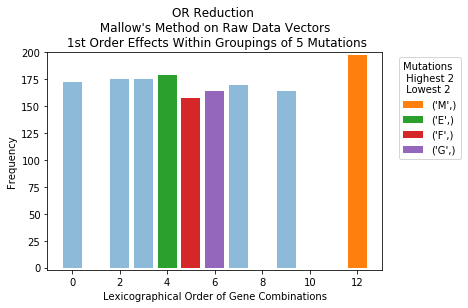

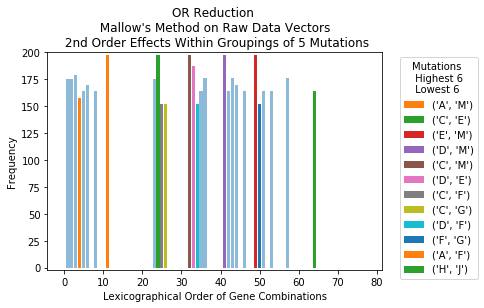

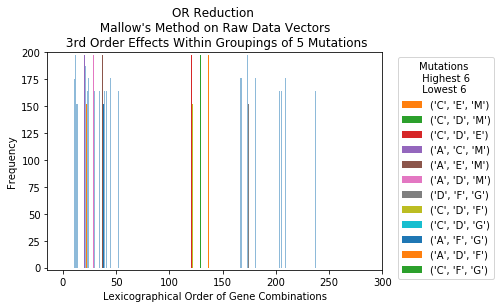

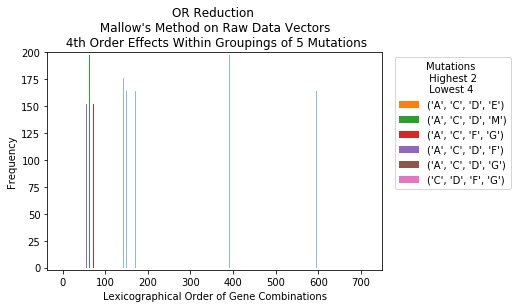

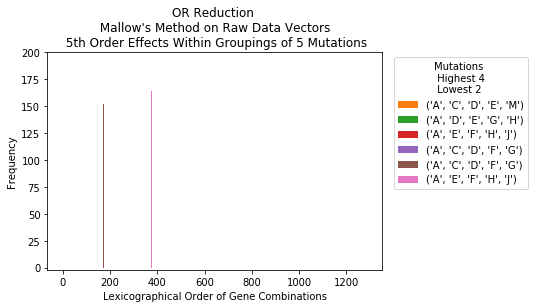

In [470]:
# Plot Raw Mallow Vectors
# f5 = MallowRawVec2[1][1]
# len(f5)
# plot f^6_1, f^6_2,..., f^6_6
# k = 5 
# order range from 1 to 6
p = ([2,2],[6,6],[6,6],[2,4],[4,2])
l = 1.25
for o in range(1,6):
    color_peaks(MallowRawVec2[1][1][o-1],order=o,k=5,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=0,save=1)
    l += 0.05

#### Access these values

In [ ]:
# match values with ids
IDRawVec = []
for order in range(1,len(f6)+1):
    fi = f6[order-1]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDRawVec.append(newfi)

In [ ]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDRawVec[5], key=itemgetter(1), reverse=True)[:13]

### Mallow vectors for $f^{(13,6)}$ raw data vector  

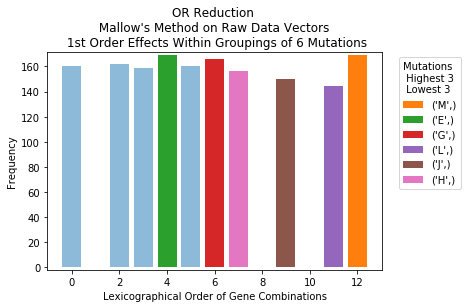

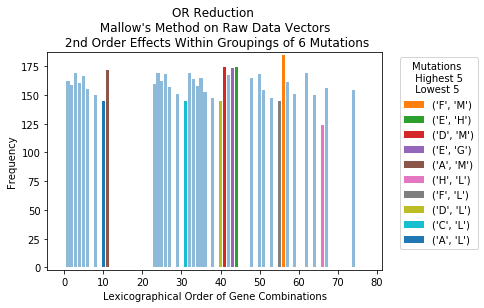

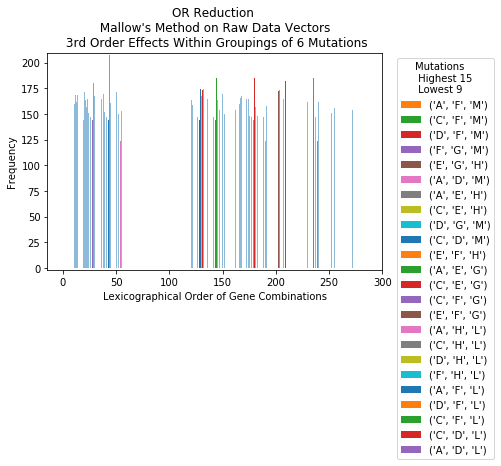

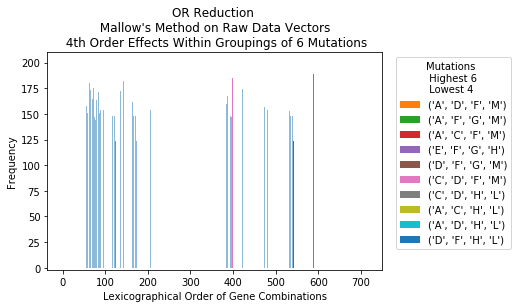

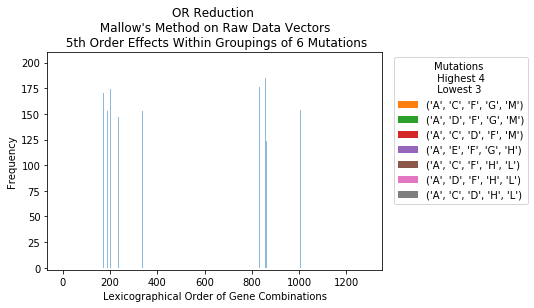

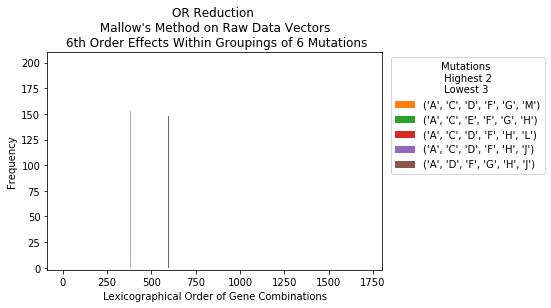

In [469]:
# Plot Raw Mallow Vectors
f6 = MallowRawVec2[0][1]
len(f6)
# plot f^6_1, f^6_2,..., f^6_6
# k = 6 
# order range from 1 to 6
p = ([3,3],[5,5],[15,9],[6,4],[4,3],[2,3])
l = 1.25
for o in range(1,7):
    color_peaks(MallowRawVec2[0][1][o-1],order=o,k=6,n_max_peak=p[o-1][0],n_min_peak=p[o-1][1],leg=l,imp=0,save=1)
    l += 0.05

#### Access these values

In [196]:
# match values with ids
IDRawVec = []
for order in range(1,len(f6)+1):
    fi = f6[order-1]
    newfi = []
    lexOrder = alphabet_choose_k(list(range(13)), order)
    for i in range(len(fi)):
        newfi.append( (lexOrder[i], fi[i]) )
    IDRawVec.append(newfi)

In [197]:
# [i] is the order-1 [e.g. 0 is first order]
sorted(IDRawVec[5], key=itemgetter(1), reverse=True)[:13]

[((0, 2, 3, 5, 6, 12), 208.0),
 ((0, 2, 4, 5, 6, 7), 189.0),
 ((0, 2, 3, 4, 6, 7), 176.0),
 ((0, 2, 3, 4, 5, 11), 165.0),
 ((2, 3, 5, 6, 7, 12), 162.0),
 ((0, 2, 3, 4, 5, 7), 159.0),
 ((0, 2, 3, 4, 5, 6), 156.0),
 ((0, 2, 6, 7, 9, 12), 154.0),
 ((0, 2, 3, 6, 7, 12), 153.0),
 ((0, 2, 3, 5, 6, 7), 148.0),
 ((0, 3, 5, 6, 7, 9), 148.0),
 ((0, 2, 3, 5, 7, 9), 147.0),
 ((0, 2, 3, 5, 7, 11), 124.0)]

# Extract values for scatterplots

In [67]:
# Sub_Data = [(5.0, M5), (6.0, M6), ..., (12.0, M12)]
# k is the grouping of mutations
# mutations is a list of the mutations you are interested in extracting 
#           e.g. [0,1,2] would be ABC
# pdata is the variable Sub_Data (always)
# combs is combinations_mutations (always)
def get_hemoglobin(k, mutations, pdata, combs):
    zeros = int(13-k)
    for i in range(len(pdata)):
        if(zeros == int(pdata[i][0])):
            data = pdata[i][1]
    hemoglobin = []
    mutation_combinations = []
    #check if mutations is in data
    # capture correct combinations to check
    for i in range(len(combinations_mutations)):
        if(int(combinations_mutations[i][0]) == int(k)):
            combinations = combinations_mutations[i][1]
    if(isin_data(mutations, combinations)):
        for row in range(len(data)):
            # categorize row by the mutations it has
            cat = categorize_row2(data[row])
            # fix some bugs here (tuples can't have length 1, work around this)
            if(isinstance(cat, int)):
                cat = [cat]
            # check if mutations happen in this row
            if(set(mutations).issubset(set(cat))):
                # save hemoglobin
                hemoglobin.append(float(data[row][-1:]))
                # save category 
                if(len(cat) == 1):
                    mutation_combinations.append(cat[0])
                else:
                    mutation_combinations.append(cat)
        # empty list for value tuples
        result = []
        for i in range(len(hemoglobin)):
            if(len(mutations) == int(k)):
                result.append( (mutation_combinations[i], hemoglobin[i]) )
            # change the elements of the list of mutations to just the one
            # we did not input in mutations variable
            else:
                # rearange mutation_combinations[i]
                a = set(mutation_combinations[i])
                b = set(mutations)
                m = sorted(list(a.difference(b)))
                m = tuple(m)
                result.append( (m, hemoglobin[i]) )
        return result
    else:
        return("these mutations don't occur in these groupings of mutations")

In [68]:
# arguments:
# 1st: is the grouping of mutations
# 2nd: is a list of the mutations you are interested in extracting 
#           e.g. [0,1,2] would be ABC
# 3rd: pdata is the variable Sub_Data (always)
# 4th: combs is combinations_mutations (always)
get_hemoglobin(5, [12], Sub_Data, combinations_mutations)

[((0, 2, 3, 4), 198.0)]

# Plot with colors

In [108]:
gene_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M']

In [105]:
# this function inputs the 13 gene names and the kth grouping of f...
# ...and outputs a list of all k combinations of gene names in lexicalgraphical order
def create_list_names(gene_names,k):
    list_names=[]
    for i in range(1,k+1):
        list_names.append(alphabet_choose_k(gene_names,i))
    return list_names

# this function inputs the list of all k combinations of gene names in lexicographical order
# ... and outputs the indices (key) for each gene group-name in list_names
def dict_names(list_names):
    keys = range(1,len(list_names)+1)
    return (dict(zip(keys,list_names)))   

# this function inputs a Mallow list with specified order and kth grouping...
# ...and outputs a single f_i mallow vector from the kth group
def Mallow_f_order(MallowList, order, k):
    for tup in MallowList:
        if (int(tup[0]))==int(k):
            list_fi= tup[1]
            return list_fi[order]
    
# input: a single mallow vector
# output: returns a list of indices which contain max vals
def get_n_max(f_i, n_max_peak):
    n = n_max_peak
    indices = f_i.ravel().argsort()[-n:]  
    top_ind=[i for i in indices]
    top_ind.reverse()
    return top_ind

# similar function as above. Returns list of indices with min vals
def get_n_min(f_i, n_min_peak):
    n= n_min_peak
    indices = f_i.ravel().argsort()[:n]
    bot_ind=[i for i in indices]
    return bot_ind

# similar as above but works for Mallow's method on raw data
def get_n_min2(f_i, n_min_peak):
    n = n_min_peak
    f = np.ma.masked_equal(f_i, 0.0, copy=False)
    indices = f.ravel().argsort()[:n]
    bot_ind=[i for i in indices]
    return bot_ind

# this function retrieves the peak name of max peaks, min peaks 
def retrieve_peak_names(diction,top_ind,order):
    order_gene_names=[]
    for i in top_ind:
        order_gene_names.append(diction.get(order)[i])
    return order_gene_names

In [461]:
#this function inputs a Mallow list, the i'th order, the kth partition, and the num of peaks...
#... and outputs a bar-plot of the i'th order effects within gene groupings of k...
#...with the max and min peaks colored
def color_peaks(MallowList, order, k, n_max_peak, n_min_peak, leg, imp, save):
    # all inputs from helper functions 
    #f_i = Mallow_f_order(MallowList, order, k)
    f_i = MallowList
    top_ind = get_n_max(f_i, n_max_peak)
    if(imp == 0):
        bot_ind = get_n_min2(f_i,n_min_peak)
    else:
        bot_ind = get_n_min(f_i,n_min_peak)
    list_names = create_list_names(gene_names,k)
    diction = dict_names(list_names)
    top_peak_gene_names = retrieve_peak_names(diction, top_ind, order)
    top_min_peak_gene_names = retrieve_peak_names(diction, bot_ind, order)
   
    # the codes below changes the size and location of things
    x_axis_1 = np.arange(len(f_i))
    
    # width changes size of bars
    plt.bar(x_axis_1, f_i, width = 0.8, align = 'center', alpha = 0.5)
    
    # axis
    # x label
    plt.xlabel('Lexicographical Order of Gene Combinations')
    # y label
    plt.ylabel('Frequency')
    
    # plotting
    plt.ylim((min(f_i)-2),(max(f_i)+2))
    for i in range(len(top_ind)):
        plt.bar(top_ind[i],f_i[top_ind[i]], align='center',label=top_peak_gene_names[i])
    for j in range(len(bot_ind)):
        plt.bar(bot_ind[j],f_i[bot_ind[j]], align='center',label=top_min_peak_gene_names[j])

    # change location of legend
    plt.legend(bbox_to_anchor=(leg, 1), title = 'Mutations \n Highest %d \n Lowest %d'%(n_max_peak, n_min_peak))
    
    #
    if(imp == 1):
        # naming the plots
        if(int(order) == 1):
            plt.title('OR Reduction \n Imputed Data Vectors \n %dst Order Effects Within Groupings of %d Mutations'%(order, k))
        elif(int(order) == 2):
            plt.title('OR Reduction \n Imputed Data Vectors \n %dnd Order Effects Within Groupings of %d Mutations'%(order, k))
        elif(int(order) == 3):
            plt.title('OR Reduction \n Imputed Data Vectors \n %drd Order Effects Within Groupings of %d Mutations'%(order, k))
        else:
            plt.title('OR Reduction \n Imputed Data Vectors \n %dth Order Effects Within Groupings of %d Mutations'%(order, k))
    else:
        if(int(order) == 1):
            plt.title('OR Reduction \n Mallow\'s Method on Raw Data Vectors \n %dst Order Effects Within Groupings of %d Mutations'%(order, k))
        elif(int(order) == 2):
            plt.title('OR Reduction \n Mallow\'s Method on Raw Data Vectors \n %dnd Order Effects Within Groupings of %d Mutations'%(order, k))
        elif(int(order) == 3):
            plt.title('OR Reduction \n Mallow\'s Method on Raw Data Vectors \n %drd Order Effects Within Groupings of %d Mutations'%(order, k))
        else:
            plt.title('OR Reduction \n Mallow\'s Method on Raw Data Vectors \n %dth Order Effects Within Groupings of %d Mutations'%(order, k))
    
    # save plots
#     if(save == 1):
#         if(imp == 1):
#             plt.savefig("OR Mutation plots/avg_%d_order_%d_mutationsOR.png"%(order, k), bbox_inches="tight")
#         else:
#             plt.savefig("OR Mutation plots/raw_%d_order_%d_mutationsOR.png"%(order, k), bbox_inches="tight")
    
    # show plots
    plt.show()

# Scatter  plots 

In [98]:
#input: list of k-grouping, mutation coallition, indexcolor for color-coding mutation coalitions on plot 
#output: plot of the hemo levels of people with list of k mutations and AT LEAST the mutation coalition inputed
def get_Hemo_of_kGroup(kList, mut_combo, indexColors):
#     counter = 0
#     avg = 0
    for i in range(len(kList)):
        list_mutGroup = get_hemoglobin(kList[i], mut_combo, Sub_Data, combinations_mutations)
        list_mutGroup_hemo=[]
        for j in range(len(list_mutGroup)):
            list_mutGroup_hemo.append((list_mutGroup)[j][1])
#             if(set([12]).issubset(set(list_mutGroup[j][0]))):
#                 print("pos=",j,"group=",kList[i], list_mutGroup[j][0],"value=",list_mutGroup[j][1])
#                 counter += 1
#                 avg += list_mutGroup[j][1]
        plt.scatter(x=range(len(list_mutGroup_hemo)),y=list_mutGroup_hemo, c="black")
        #colorcode mutation coalition by indexcolor
        for c in range(len(indexColors[i])):
            plt.scatter(x=[indexColors[i][c][0]],y=[(list_mutGroup_hemo[indexColors[i][c][0]])], c=indexColors[i][c][1], label=indexColors[i][c][2])    
#     print("sum = ", avg, "count  = ", counter)
#extra plot code 
    plt.xlabel("Observations (In No Specific Order)") #this should remain the same
    plt.ylabel("Hemoglobin Level") #this should remain the same
    plt.title("OR Reduction \n Hemoglobin Levels of People with 5 and 6 Mutations \n and Mutation M and Coalition HM")
    plt.tight_layout()
    plt.ylim(60, 250) #this should remain the same 
    plt.axhline(y = 163.5, color='k',linewidth=1.2, label="Average")
    plt.axhline(y = 175, color='m',linewidth=1.2, label="M Avg. \n 175")
    plt.axhline(y = 156.3, color='g',linewidth=1.2, label="HM Avg. \n 156.3")
    plt.legend(loc="best",bbox_to_anchor=(1.01,1),title="Coalitions") 
#     plt.savefig("Scatterplots/OR_HemoLevels.png", bbox_inches= "tight")
    return plt.show()

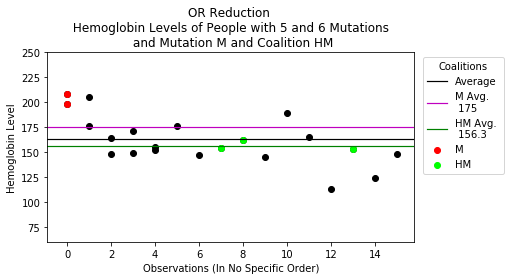

None


In [99]:
c = "RED"
a = "lime"
print(get_Hemo_of_kGroup(kList = [5,6], mut_combo = [], 
                         indexColors = [[(0,c,"M")],
                                        [(0,c,""),(7,a,"HM"),(8,a,""),(13,a,"")]] ) )